In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import events_from_scdinfo


from fvt_classifier import FvTClassifier


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [5]:
from itertools import product
from dataset import generate_mother_dataset, split_scdinfo
from fvt_classifier import FvTClassifier
from training_info import TrainingInfoV2

import torch
import numpy as np
import pytorch_lightning as pl

device = torch.device("cuda")

dim_input_jet_features = 4
num_classes = 2

ratio_4b = 0.5
seed = 0
signal_filename = "HH4b_picoAOD.h5"

fvt_results = []

# Case 1: Signal ratio fixed to 0.05

scdinfo_all, df_all = generate_mother_dataset(
    n_3b=200000,
    ratio_4b=ratio_4b,
    signal_ratio=0.05,
    signal_filename=signal_filename,
    seed=seed,
)

scdinfo_base_train, scdinfo_test = split_scdinfo(
    scdinfo_all, 0.5, seed
)

for n_train in [50000, 100000, 200000]:
    idx = np.random.permutation(len(scdinfo_base_train))[:n_train]
    scdinfo_base_train_sub = scdinfo_base_train[idx]

    base_fvt_hparams = {
        "dim_dijet_features": 6,
        "dim_quadjet_features": 6,
        "lr": 0.001,
        "batch_size": 1024,
        "max_epochs": 30,
        "train_seed": seed,
        "fit_batch_size": True, 
        "data_seed": seed,
        "val_ratio": 0.33
    }

    pl.seed_everything(seed)
    np.random.seed(seed)

    base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_train_sub)
    
    base_fvt_train_dset, base_fvt_val_dset = (
        base_fvt_tinfo.fetch_train_val_tensor_datasets(
            features, "fourTag", "weight")
    )

    base_fvt_model = FvTClassifier(
        num_classes,
        dim_input_jet_features,
        base_fvt_hparams["dim_dijet_features"],
        base_fvt_hparams["dim_quadjet_features"],
        run_name=base_fvt_tinfo.hash,
        device=torch.device("cuda:0"),
        lr=base_fvt_hparams["lr"],
    )

    base_fvt_model.fit(
        base_fvt_train_dset,
        base_fvt_val_dset,
        batch_size=base_fvt_hparams["batch_size"],
        max_epochs=base_fvt_hparams["max_epochs"],
        train_seed=base_fvt_hparams["train_seed"],
        save_checkpoint=False
    )
    base_fvt_model.eval()
    base_fvt_model.to(device)

    events_test = events_from_scdinfo(scdinfo_test, features, signal_filename)
    probs_est = base_fvt_model.predict(events_test.X_torch)[:, 1].cpu().numpy()
    
    fvt_results.append({
        "n_train": n_train,
        "probs_est": probs_est
    })

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
[n01:1259155] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.n01.3393/jf.0/1907621888/shared_mem_cuda_pool.n01 could be created.
[n01:1259155] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your syst

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, v_num=0, val_loss=0.661, train_loss=0.661]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, v_num=0, val_loss=0.661, train_loss=0.661]


[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 65/65 [00:07<00:00,  8.82it/s, v_num=0, val_loss=0.657, train_loss=0.661]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 65/65 [00:07<00:00,  8.45it/s, v_num=0, val_loss=0.657, train_loss=0.661]


[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 130/130 [00:11<00:00, 10.86it/s, v_num=0, val_loss=0.655, train_loss=0.658]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 130/130 [00:12<00:00, 10.58it/s, v_num=0, val_loss=0.655, train_loss=0.658]


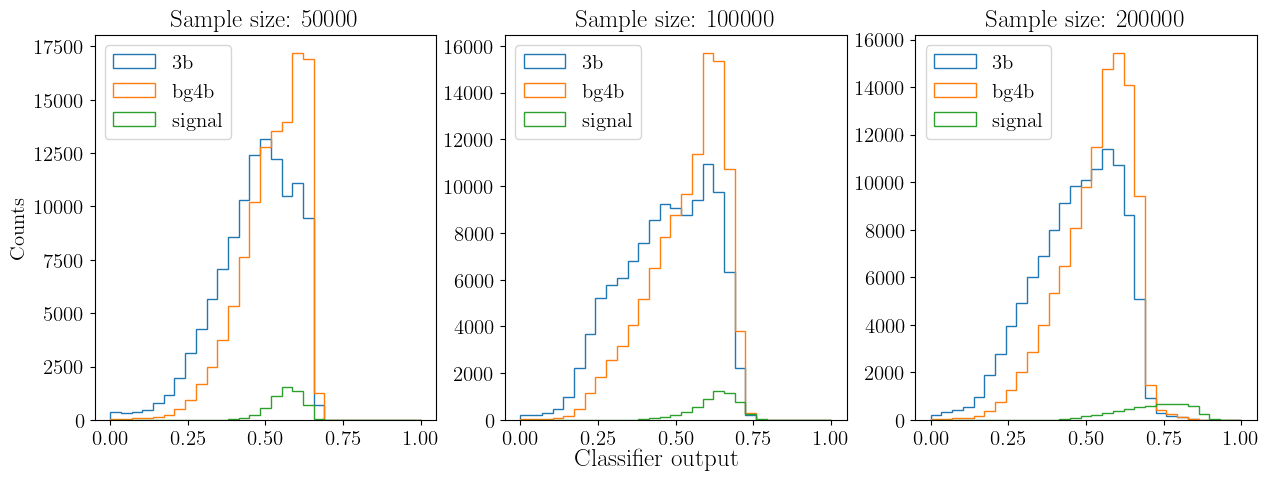

In [14]:
# density plot

# use latex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15

scdinfo_all, df_all = generate_mother_dataset(
    n_3b=200000,
    ratio_4b=ratio_4b,
    signal_ratio=0.05,
    signal_filename=signal_filename,
    seed=seed,
)

scdinfo_base_train, scdinfo_test = split_scdinfo(
    scdinfo_all, 0.5, seed
)

events_test = events_from_scdinfo(scdinfo_test, features, signal_filename)

bins = np.linspace(0, 1, 30)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.supxlabel("Classifier output")
ax[0].set_ylabel("Counts")
for i, res in enumerate(fvt_results):
    ax[i].set_title(f"Sample size: {res['n_train']}")
    hist_events_by_labels(events_test, res["probs_est"], bins=bins, ax=ax[i])
    ax[i].legend()
plt.savefig("fixed_signal_ratio.pdf", dpi=300)
plt.show()
plt.close()

In [7]:
# Case 2: n_train is fixed to 100k, signal ratio is varied

n_3b = 100000

fvt_results_sr = []
for signal_ratio in [0.025, 0.05, 0.1]:
    scdinfo_all, df_all = generate_mother_dataset(
        n_3b=n_3b,
        ratio_4b=ratio_4b,
        signal_ratio=signal_ratio,
        signal_filename=signal_filename,
        seed=seed
    )
    
    scdinfo_base_train, scdinfo_test = split_scdinfo(
        scdinfo_all, 0.5, seed
    )

    idx = np.random.permutation(len(scdinfo_base_train))[:n_train]
    scdinfo_base_train_sub = scdinfo_base_train[idx]

    base_fvt_hparams = {
        "dim_dijet_features": 6,
        "dim_quadjet_features": 6,
        "lr": 0.001,
        "batch_size": 1024,
        "max_epochs": 30,
        "train_seed": seed,
        "fit_batch_size": True, 
        "data_seed": seed,
        "val_ratio": 0.33
    }
    
    pl.seed_everything(seed)
    np.random.seed(seed)

    base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_train_sub)
    
    base_fvt_train_dset, base_fvt_val_dset = (
        base_fvt_tinfo.fetch_train_val_tensor_datasets(
            features, "fourTag", "weight")
    )

    base_fvt_model = FvTClassifier(
        num_classes,
        dim_input_jet_features,
        base_fvt_hparams["dim_dijet_features"],
        base_fvt_hparams["dim_quadjet_features"],
        run_name=base_fvt_tinfo.hash,
        device=torch.device("cuda:0"),
        lr=base_fvt_hparams["lr"],
    )

    base_fvt_model.fit(
        base_fvt_train_dset,
        base_fvt_val_dset,
        batch_size=base_fvt_hparams["batch_size"],
        max_epochs=base_fvt_hparams["max_epochs"],
        train_seed=base_fvt_hparams["train_seed"],
        save_checkpoint=False
    )

    base_fvt_model.eval()
    base_fvt_model.to(device)

    events_test = events_from_scdinfo(scdinfo_test, features, signal_filename)
    probs_est = base_fvt_model.predict(events_test.X_torch)[:, 1].cpu().numpy()
    
    fvt_results_sr.append({
        "signal_ratio": signal_ratio,
        "probs_est": probs_est,
        "events_test": events_test
    })

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 28: 100%|██████████| 68/68 [00:09<00:00,  7.44it/s, v_num=0, val_loss=0.663, train_loss=0.662]


[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 68/68 [00:06<00:00,  9.99it/s, v_num=0, val_loss=0.659, train_loss=0.659]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 68/68 [00:06<00:00,  9.92it/s, v_num=0, val_loss=0.659, train_loss=0.659]


[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 68/68 [00:04<00:00, 14.56it/s, v_num=0, val_loss=0.649, train_loss=0.649]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 68/68 [00:04<00:00, 14.44it/s, v_num=0, val_loss=0.649, train_loss=0.649]


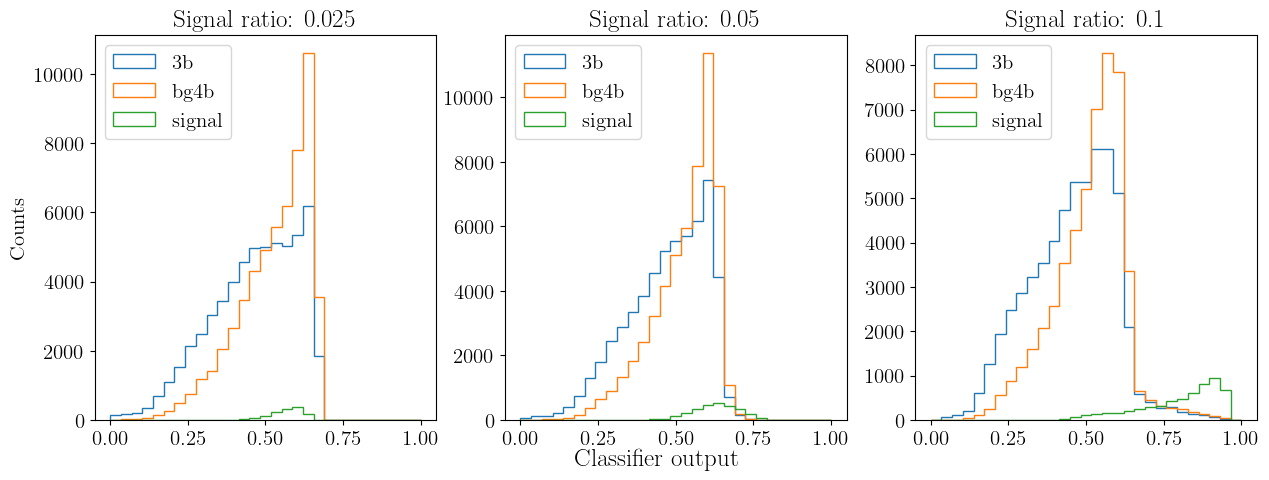

In [13]:
bins = np.linspace(0, 1, 30)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.supxlabel("Classifier output")
ax[0].set_ylabel("Counts")
for i, res in enumerate(fvt_results_sr):
    ax[i].set_title(f"Signal ratio: {res['signal_ratio']}")
    hist_events_by_labels(res["events_test"], res["probs_est"], bins=bins, ax=ax[i])
    ax[i].legend()
plt.savefig("fixed_n_train.pdf", dpi=300)
plt.show()
plt.close()